In [20]:
# %% [markdown]
# # Network Intrusion Detection - Machine Learning Workflow
#
# This notebook walks through preprocessing, training, evaluating, and visualizing machine learning models for network intrusion detection using the provided dataset.

# %%
# Core libraries
import pandas as pd
import numpy as np
import time  # To time processes

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB # Added Gaussian Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Added Decision Tree
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC # SVM can be very slow on large datasets, commented out initially
# from sklearn.neural_network import MLPClassifier # Optional: Uncomment if you want to use MLP

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif # Example for explicit feature selection

# Settings
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style
pd.set_option('display.max_columns', None) # Show all columns in DataFrames
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

print("Libraries imported successfully.")

Libraries imported successfully.


In [21]:
# %% [markdown]
# ## 1. Load Data
#
# Load the training and testing datasets. We will primarily use `Train_data.csv` for model development and evaluation by splitting it. The separate `Test_data.csv` might be used for final blind testing if it has the same structure and labels, or for prediction if labels are absent (typical Kaggle scenario).

# %%
# --- Define File Paths ---
# <<< --- IMPORTANT: These paths are based on your input. Double-check them! --- >>>
train_file_path = 'Data/Train_data.csv'
test_file_path = 'Data/Test_data.csv'

# --- Load DataFrames ---
try:
    start_time = time.time()
    df_train_full = pd.read_csv(train_file_path)
    # df_test_full = pd.read_csv(test_file_path) # Load the separate test set if needed later
    end_time = time.time()
    print(f"Training Data Loaded Successfully from: {train_file_path}")
    # print(f"Test Data Loaded Successfully from: {test_file_path}")
    print(f"Time taken to load data: {end_time - start_time:.2f} seconds")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the file paths are correct.")
    # Stop execution if files not found
    raise SystemExit("Data files not found.")

except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    raise SystemExit("Data loading failed.")

Training Data Loaded Successfully from: Data/Train_data.csv
Time taken to load data: 0.05 seconds


--- Training Data Overview ---
Shape (rows, columns): (25192, 42)

First 5 rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal



Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-nu

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Missing values per column:
Series([], dtype: int64)

Target variable ('class') identified.

Distribution of Target Variable ('class'):
class
normal     13449
anomaly    11743
Name: count, dtype: int64


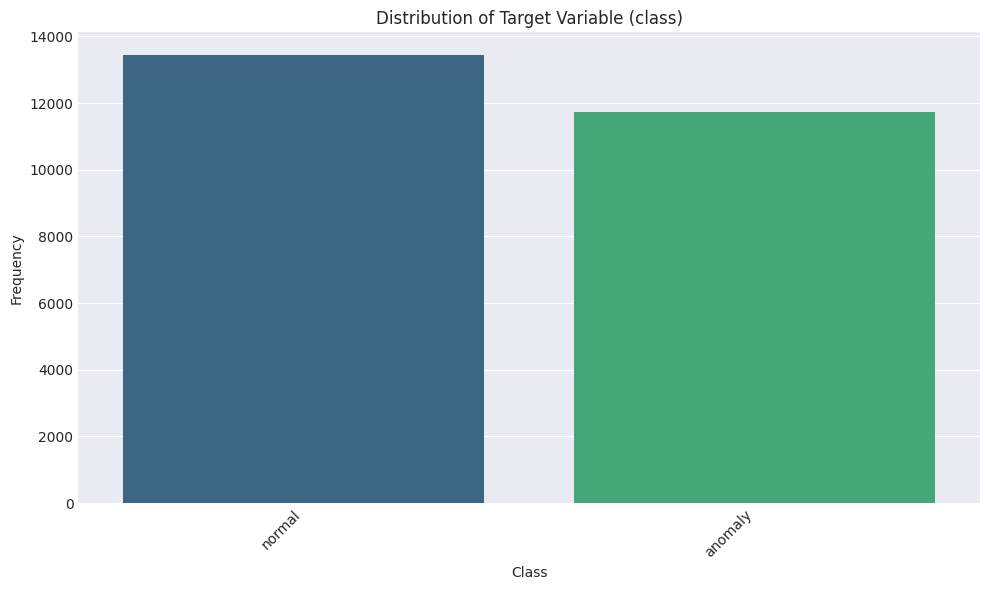


Number of unique classes: 2
This appears to be a Binary Classification problem.


In [22]:
# %% [markdown]
# ## 2. Initial Data Exploration
#
# Get a feel for the training data: check its shape, data types, look for missing values, and understand the distribution of the target variable.

# %%
print("--- Training Data Overview ---")
print(f"Shape (rows, columns): {df_train_full.shape}")

print("\nFirst 5 rows:")
display(df_train_full.head()) # Use display() in Jupyter for better formatting

print("\nData Types and Non-Null Counts:")
df_train_full.info()

print("\nSummary Statistics for Numerical Features:")
display(df_train_full.describe())

print("\nMissing values per column:")
print(df_train_full.isnull().sum()[df_train_full.isnull().sum() > 0]) # Only show columns with missing values

# --- Identify Target Variable ---
# *** INSPECT df_train_full.columns and df_train_full.head() TO CONFIRM THE TARGET COLUMN NAME ***
# Common names: 'class', 'label', 'attack_cat', 'intrusion', 'outcome' etc.
target_column = 'class' # <<< --- !!! VERIFY AND CHANGE THIS IF NEEDED !!! --- >>>

if target_column not in df_train_full.columns:
    print(f"\nError: Target column '{target_column}' not found in the DataFrame.")
    print("Available columns:", df_train_full.columns)
    # Stop execution
    raise SystemExit(f"Target column '{target_column}' not found.")
else:
    print(f"\nTarget variable ('{target_column}') identified.")

# --- Analyze Target Variable Distribution ---
print(f"\nDistribution of Target Variable ('{target_column}'):")
target_counts = df_train_full[target_column].value_counts()
print(target_counts)

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=target_column, data=df_train_full, order=target_counts.index, palette='viridis')
plt.title(f'Distribution of Target Variable ({target_column})')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check if it's a binary or multi-class problem
num_classes = df_train_full[target_column].nunique()
print(f"\nNumber of unique classes: {num_classes}")
if num_classes == 2:
    print("This appears to be a Binary Classification problem.")
else:
    print("This appears to be a Multi-Class Classification problem.")

In [23]:
# %% [markdown]
# ## 3. Prepare Features and Target
#
# Separate the dataset into features (X) and the target variable (y). Encode the target variable into numerical format.

# %%
# --- Define Features (X) and Target (y) ---
X = df_train_full.drop(target_column, axis=1)
y = df_train_full[target_column]

print(f"Features shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")

# --- Encode the Target Variable ---
# Convert string labels (like 'normal', 'dos') into numerical labels (0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nTarget Variable Encoding:")
print(f"Original labels mapped: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"Encoded y shape: {y_encoded.shape}")
target_labels = le.classes_ # Store readable labels for later use in reports/plots

Features shape (X): (25192, 41)
Target shape (y): (25192,)

Target Variable Encoding:
Original labels mapped: {'anomaly': np.int64(0), 'normal': np.int64(1)}
Encoded y shape: (25192,)


In [24]:
# %% [markdown]
# ## 4. Identify Feature Types
#
# Automatically separate features into numerical and categorical types for applying different preprocessing steps.

# %%
# --- Identify Numerical and Categorical Features ---
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"Identified {len(numerical_cols)} numerical columns:")
# print(numerical_cols) # Uncomment to see the full list
print(f"Identified {len(categorical_cols)} categorical columns:")
print(categorical_cols) # Print categorical columns (often fewer)

# Sanity check: Ensure all columns are accounted for
assert len(numerical_cols) + len(categorical_cols) == X.shape[1], "Mismatch in column types identification!"

Identified 38 numerical columns:
Identified 3 categorical columns:
['protocol_type', 'service', 'flag']


In [25]:
# %% [markdown]
# ## 5. Define Preprocessing Steps
#
# Create pipelines for preprocessing:
# - **Numerical Features:** Scaling (e.g., StandardScaler). Add imputation if missing values were found.
# - **Categorical Features:** One-Hot Encoding. Add imputation if missing values were found.
#
# Combine these steps using `ColumnTransformer`.

# %%
# --- Create Preprocessing Pipelines ---

# Pipeline for numerical features: Scale data to have zero mean and unit variance.
# Add SimpleImputer(strategy='median') if numerical columns have NaNs
numerical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')), # Uncomment if needed
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: One-hot encode categorical variables.
# Add SimpleImputer(strategy='most_frequent') if categorical columns have NaNs
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')), # Uncomment if needed
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False might use more memory but can be easier for some models/inspection
])

# --- Create Column Transformer ---
# Apply the pipelines to the correct column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep any columns not specified (shouldn't happen here)
)

print("Preprocessing pipelines defined.")
print(preprocessor)

Preprocessing pipelines defined.
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['duration', 'src_bytes', 'dst_bytes', 'land',
                                  'wrong_fragment', 'urgent', 'hot',
                                  'num_failed_logins', 'logged_in',
                                  'num_compromised', 'root_shell',
                                  'su_attempted', 'num_root',
                                  'num_file_creations', 'num_shells',
                                  'num_access_files', 'num_outbound_cmds',
                                  'is_host_login', 'is_guest_login', 'count',
                                  'srv_count', 'serror_rate', 'srv_serror_rate',
                                  'rerror_rate', 'srv_rerror_rate',
                                  'same_srv_rate', 'diff_srv_rate',
                 

In [26]:
# %% [markdown]
# ## 6. Split Data into Training and Testing Sets
#
# Split the `Train_data.csv` into training and testing subsets. This allows us to evaluate the model's performance on data it hasn't seen during training. We use stratification to maintain the original class distribution in both sets.

# %%
# --- Split Data ---
# Use the original X and the encoded y (y_encoded)
# Stratify ensures representative splits, especially important for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,        # Use 30% of the data for testing
    random_state=42,      # Ensures reproducibility of the split
    stratify=y_encoded    # Maintain class proportions in train and test sets
)

print("--- Data Split ---")
print(f"Original dataset size: {X.shape[0]} samples")
print(f"Training set size:   {X_train.shape[0]} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size:    {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification (optional check)
print("\nOriginal target distribution:")
print(pd.Series(y_encoded).value_counts(normalize=True).sort_index())
print("\nTraining set target distribution:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print("\nTesting set target distribution:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index())

--- Data Split ---
Original dataset size: 25192 samples
Training set size:   17634 samples (70.0%)
Testing set size:    7558 samples (30.0%)

Original target distribution:
0    0.46614
1    0.53386
Name: proportion, dtype: float64

Training set target distribution:
0    0.466145
1    0.533855
Name: proportion, dtype: float64

Testing set target distribution:
0    0.466129
1    0.533871
Name: proportion, dtype: float64


In [27]:
# %% [markdown]
# ## 7. Apply Preprocessing
#
# Fit the preprocessor on the **training data only** to learn the scaling parameters and categories. Then, transform both the training and testing data.

# %%
# --- Fit and Transform Data ---
print("Applying preprocessing (fitting on train, transforming train & test)...")
start_time = time.time()

# Fit the preprocessor on the training data and transform it
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data using the *already fitted* preprocessor
X_test_processed = preprocessor.transform(X_test)

end_time = time.time()
print(f"Preprocessing completed in {end_time - start_time:.2f} seconds.")
print(f"\nShape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed testing data:  {X_test_processed.shape}")

# --- Get Feature Names After Preprocessing ---
# This is useful for feature importance analysis later
try:
    # Get feature names from the fitted preprocessor
    feature_names_out = preprocessor.get_feature_names_out()
    print(f"\nNumber of features after preprocessing: {len(feature_names_out)}")
    # print("First 20 feature names:", feature_names_out[:20]) # Print sample names
except AttributeError:
    # Handling for older scikit-learn versions if needed
    print("\nWarning: Could not get feature names automatically (requires scikit-learn >= 1.0).")
    feature_names_out = None # Set to None if unavailable
except Exception as e:
    print(f"\nAn error occurred getting feature names: {e}")
    feature_names_out = None


# Convert processed arrays back to DataFrames (optional, can use more memory)
# Useful for inspection, but models work directly with numpy arrays
# X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out if feature_names_out is not None else None)
# X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out if feature_names_out is not None else None)
# display(X_train_processed_df.head())

Applying preprocessing (fitting on train, transforming train & test)...
Preprocessing completed in 0.04 seconds.

Shape of processed training data: (17634, 117)
Shape of processed testing data:  (7558, 117)

Number of features after preprocessing: 117


In [28]:
# %% [markdown]
# ## 8. (Optional) Feature Selection
#
# Apply feature selection techniques if desired. This example uses `SelectKBest` with the F-statistic for classification. Random Forest also performs implicit feature selection. You might skip this or use other methods (e.g., RFE).

# %%
# --- Feature Selection using SelectKBest (Example) ---
# Set to True to run this section, False to skip
APPLY_FEATURE_SELECTION = False

if APPLY_FEATURE_SELECTION:
    k_features = 50 # Select the top 50 features (adjust as needed)
    print(f"\nApplying SelectKBest to select top {k_features} features...")
    start_time = time.time()

    selector = SelectKBest(score_func=f_classif, k=k_features)

    # Fit on processed training data
    X_train_selected = selector.fit_transform(X_train_processed, y_train)
    # Transform processed test data
    X_test_selected = selector.transform(X_test_processed)

    end_time = time.time()
    print(f"Feature selection completed in {end_time - start_time:.2f} seconds.")
    print(f"Shape after selecting features: Train={X_train_selected.shape}, Test={X_test_selected.shape}")

    # Get selected feature names (if available)
    selected_feature_names = None
    if feature_names_out is not None:
        selected_indices = selector.get_support(indices=True)
        selected_feature_names = [feature_names_out[i] for i in selected_indices]
        print(f"Selected feature names ({len(selected_feature_names)}):")
        print(selected_feature_names[:15]) # Print first 15 selected

    # IMPORTANT: If feature selection is applied, use X_train_selected and X_test_selected
    # for model training and evaluation below.
    X_train_final = X_train_selected
    X_test_final = X_test_selected
    feature_names_final = selected_feature_names
else:
    print("\nSkipping explicit feature selection.")
    # Use the fully preprocessed data if skipping selection
    X_train_final = X_train_processed
    X_test_final = X_test_processed
    feature_names_final = feature_names_out # Use all feature names


Skipping explicit feature selection.


In [29]:
# %% [markdown]
# ## 9. Define Machine Learning Models
#
# Initialize the machine learning models we want to train and compare. We'll start with simpler/faster models and optionally include more complex ones.

# %%
# --- Define Models ---
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'), # n_jobs=-1 uses all cores, class_weight helps with imbalance
    "Gaussian Naive Bayes": GaussianNB(),
    # "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'), # Can be very slow, keep commented unless needed
    # "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42, early_stopping=True, alpha=0.001) # Example MLP config
}

print(f"Models to be trained: {list(models.keys())}")

Models to be trained: ['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes']


In [30]:
# %% [markdown]
# ## 10. Train Models
#
# Train each defined model on the preprocessed (and potentially feature-selected) training data.

# %%
# --- Train Models ---
trained_models = {}
training_times = {}

print("\n--- Starting Model Training ---")

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()

    # Train the model using the final training data (processed/selected)
    model.fit(X_train_final, y_train)

    end_time = time.time()
    elapsed_time = end_time - start_time
    trained_models[name] = model
    training_times[name] = elapsed_time
    print(f"{name} trained successfully in {elapsed_time:.2f} seconds.")

print("\n--- Model Training Complete ---")


--- Starting Model Training ---
Training Decision Tree...
Decision Tree trained successfully in 0.22 seconds.
Training Random Forest...
Random Forest trained successfully in 0.81 seconds.
Training Gaussian Naive Bayes...
Gaussian Naive Bayes trained successfully in 0.02 seconds.

--- Model Training Complete ---


In [31]:
# %% [markdown]
# ## 11. Define Evaluation Function
#
# Create a helper function to calculate and display standard classification metrics.

# %%
# --- Evaluation Helper Function ---

def evaluate_model(name, model, X_test, y_test, labels, X_train=None, y_train=None):
    """Calculates, prints, and returns evaluation metrics."""
    print(f"\n--- Evaluating {name} ---")

    # --- Test Set Evaluation ---
    print("Evaluating on Test Set...")
    start_time = time.time()
    y_pred_test = model.predict(X_test)
    end_time = time.time()
    test_prediction_time = end_time - start_time

    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Use 'weighted' average for imbalanced classes to account for label imbalance.
    # 'macro' treats all classes equally.
    precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

    print(f"Test Set Prediction Time: {test_prediction_time:.4f} seconds")
    print(f"Test Accuracy:  {accuracy_test:.4f}")
    print(f"Test Precision (Weighted): {precision_test:.4f}")
    print(f"Test Recall (Weighted):    {recall_test:.4f}")
    print(f"Test F1-Score (Weighted):  {f1_test:.4f}")

    print("\nTest Set Classification Report:")
    # Use target_names for readable report based on original labels
    print(classification_report(y_test, y_pred_test, target_names=labels, zero_division=0))

    # --- (Optional) Training Set Evaluation ---
    # Helps check for overfitting (large gap between train and test scores)
    accuracy_train, precision_train, recall_train, f1_train = None, None, None, None
    if X_train is not None and y_train is not None:
        print("\nEvaluating on Training Set (for overfitting check)...")
        y_pred_train = model.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        precision_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
        recall_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
        f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
        print(f"Train Accuracy: {accuracy_train:.4f}")
        # print(f"Train F1-Score (Weighted): {f1_train:.4f}") # Uncomment if desired

    return {
        'model_name': name,
        'test_accuracy': accuracy_test,
        'test_precision': precision_test,
        'test_recall': recall_test,
        'test_f1': f1_test,
        'test_predictions': y_pred_test,
        'train_accuracy': accuracy_train, # Will be None if not calculated
        'train_f1': f1_train, # Will be None if not calculated
        'test_prediction_time': test_prediction_time
    }

print("Evaluation function defined.")

Evaluation function defined.


In [32]:
# %% [markdown]
# ## 12. Evaluate Models
#
# Run the evaluation function for each trained model using the test set. Optionally evaluate on the training set too to check for overfitting.

# %%
# --- Evaluate All Trained Models ---
results = []

for name, model in trained_models.items():
    # Evaluate on test set and optionally on train set
    # Pass X_train_final, y_train to calculate training scores
    eval_metrics = evaluate_model(name, model, X_test_final, y_test, target_labels, X_train_final, y_train)
    eval_metrics['training_time'] = training_times[name] # Add training time to results
    results.append(eval_metrics)

# --- Store Results in a DataFrame ---
results_df = pd.DataFrame(results)
results_df.set_index('model_name', inplace=True)

print("\n\n--- Summary of Evaluation Results ---")
display(results_df[['train_accuracy', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'training_time', 'test_prediction_time']])


--- Evaluating Decision Tree ---
Evaluating on Test Set...
Test Set Prediction Time: 0.0017 seconds
Test Accuracy:  0.9960
Test Precision (Weighted): 0.9960
Test Recall (Weighted):    0.9960
Test F1-Score (Weighted):  0.9960

Test Set Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      3523
      normal       1.00      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558


Evaluating on Training Set (for overfitting check)...
Train Accuracy: 1.0000

--- Evaluating Random Forest ---
Evaluating on Test Set...
Test Set Prediction Time: 0.0362 seconds
Test Accuracy:  0.9976
Test Precision (Weighted): 0.9976
Test Recall (Weighted):    0.9976
Test F1-Score (Weighted):  0.9976

Test Set Classification Report:
              precision    recall  f1-score   support

     anomaly       1.0

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1,training_time,test_prediction_time
model_name,,,,,,,
Decision Tree,1.000000,0.996031,0.996031,0.996031,0.996031,0.216706,0.001672
Random Forest,1.000000,0.997618,0.997625,0.997618,0.997618,0.809780,0.036222
Gaussian Naive Bayes,0.862482,0.857899,0.886999,0.857899,0.853552,0.015995,0.004154


In [33]:
# %% [markdown]
# ## 13. Define Confusion Matrix Visualization Function
#
# Create a function to plot the confusion matrix for a model's predictions.

# %%
# --- Confusion Matrix Plotting Function ---
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Plots a confusion matrix using Seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 8}) # Smaller annotations if many classes
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("Confusion matrix plotting function defined.")

Confusion matrix plotting function defined.



--- Generating Confusion Matrices ---


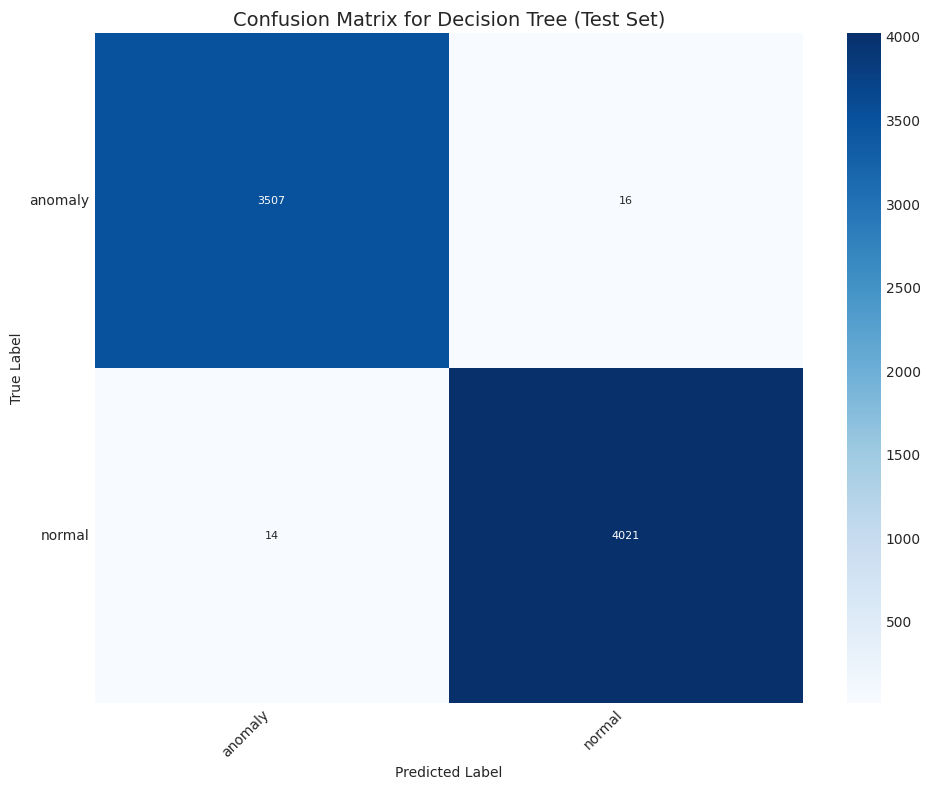

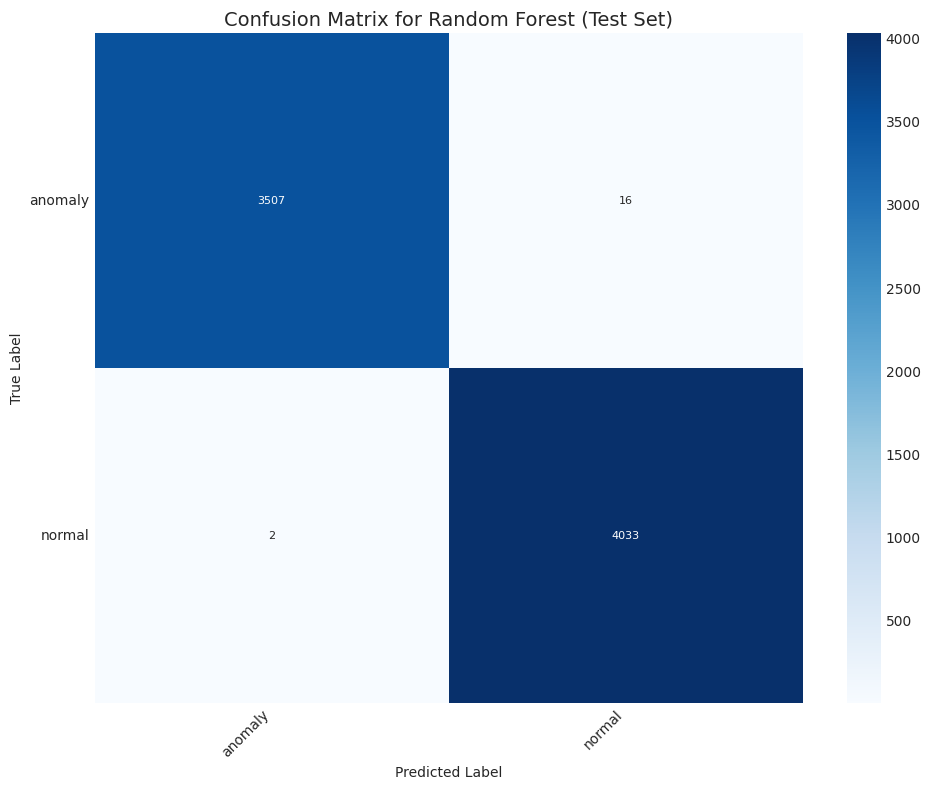

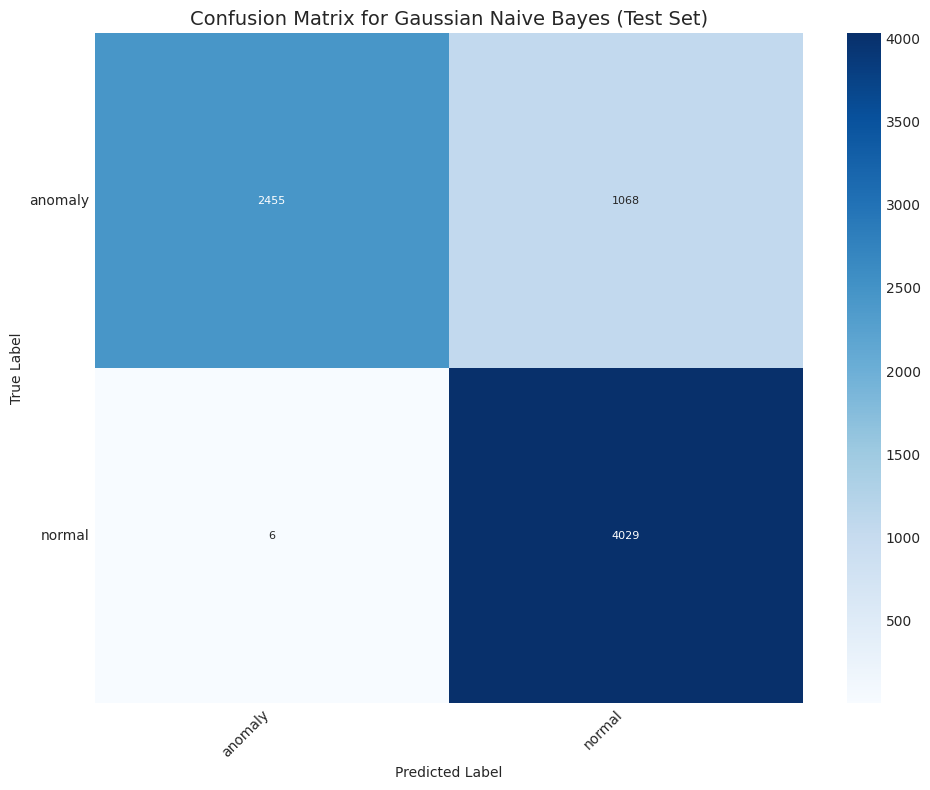

In [34]:
# %% [markdown]
# ## 14. Visualize Confusion Matrices
#
# Generate and display the confusion matrix for each model evaluated.

# %%
# --- Plot Confusion Matrices for Each Model ---
print("\n--- Generating Confusion Matrices ---")
for result in results:
    model_name = result['model_name']
    y_pred_test = result['test_predictions']
    plot_confusion_matrix(y_test, y_pred_test, target_labels, f'Confusion Matrix for {model_name} (Test Set)')


--- Generating Feature Importance Plots ---
Calculating feature importance for Decision Tree...


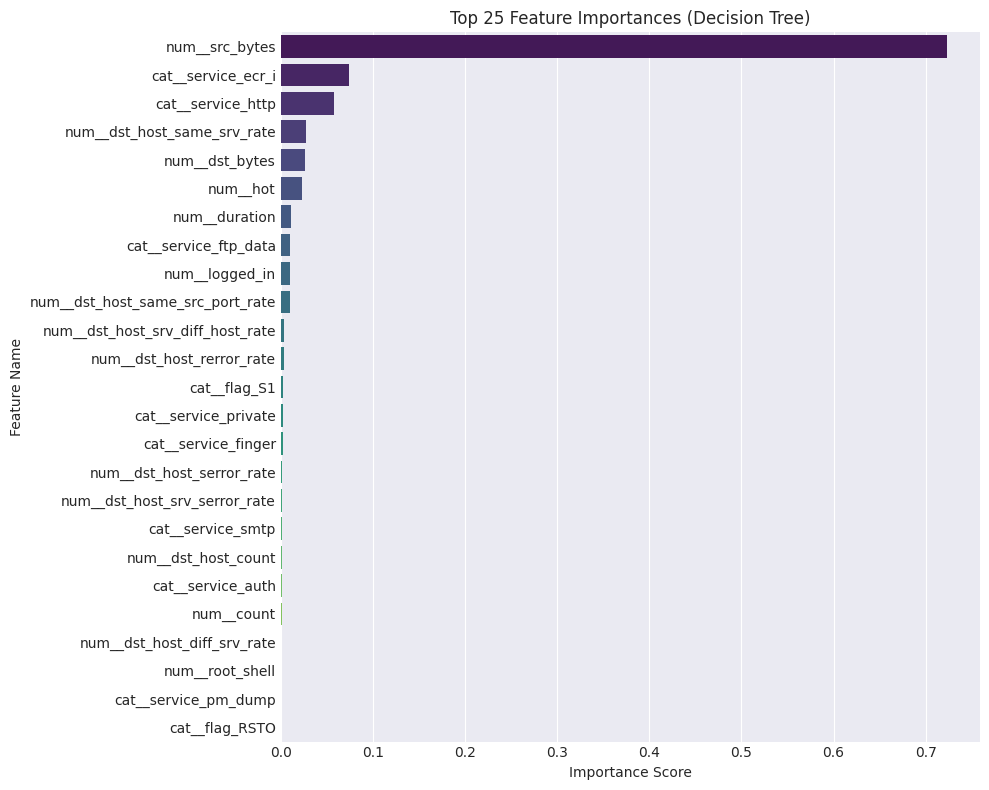

Calculating feature importance for Random Forest...


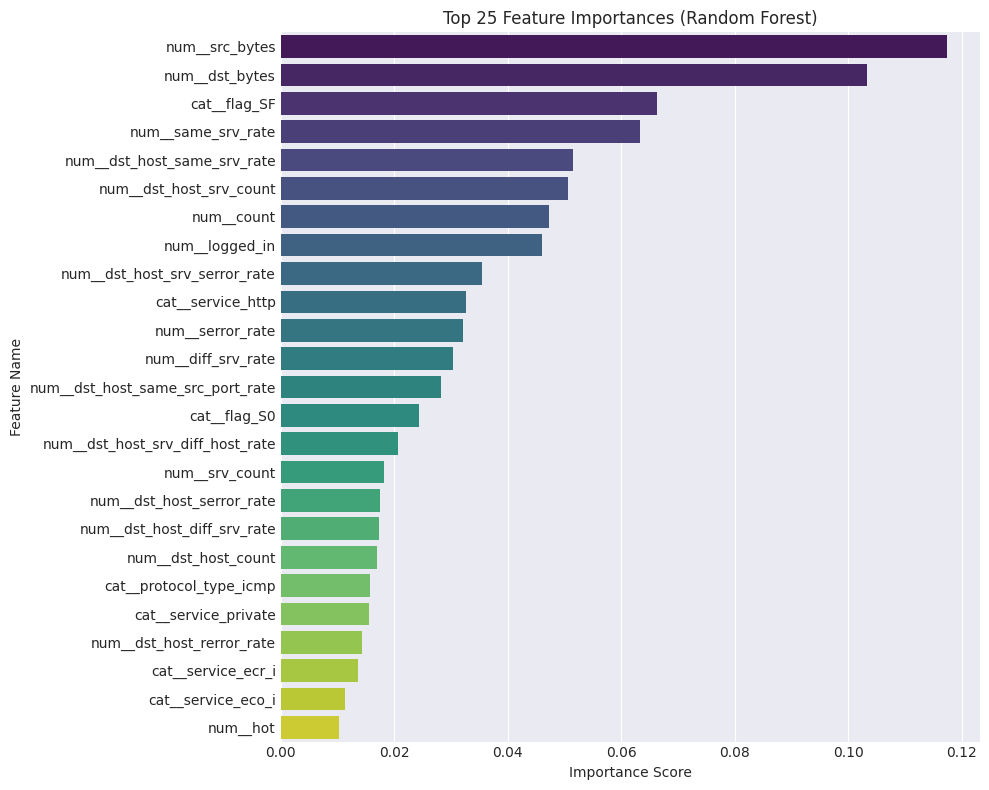

Feature importance not available for model type: Gaussian Naive Bayes


In [35]:
# %% [markdown]
# ## 15. Analyze Feature Importance
#
# Visualize the feature importances for models that provide this information (like Random Forest and Decision Tree). This requires the feature names obtained after preprocessing.

# %%
# --- Feature Importance Analysis ---

# Check if feature names are available
if feature_names_final is None:
    print("\nCannot show feature importance plots because feature names after preprocessing are not available.")
else:
    print("\n--- Generating Feature Importance Plots ---")
    for name, model in trained_models.items():
        # Check if the model has the 'feature_importances_' attribute
        if hasattr(model, 'feature_importances_'):
            print(f"Calculating feature importance for {name}...")
            importances = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': feature_names_final, # Use names corresponding to X_train_final/X_test_final
                'importance': importances
            }).sort_values(by='importance', ascending=False)

            # Plot top N features
            top_n = 25
            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette='viridis')
            plt.title(f'Top {top_n} Feature Importances ({name})')
            plt.xlabel('Importance Score')
            plt.ylabel('Feature Name')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Feature importance not available for model type: {name}")


--- Comparing Model Performance Metrics ---


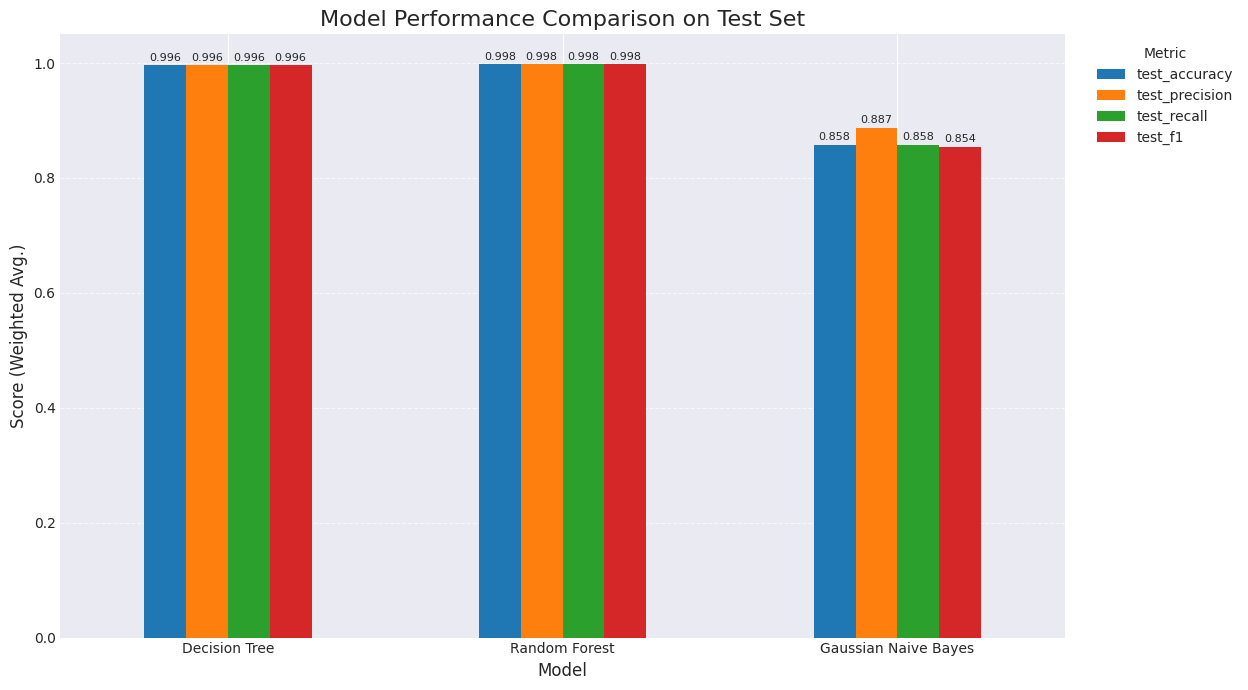


--- Comparing Model Training and Prediction Times ---


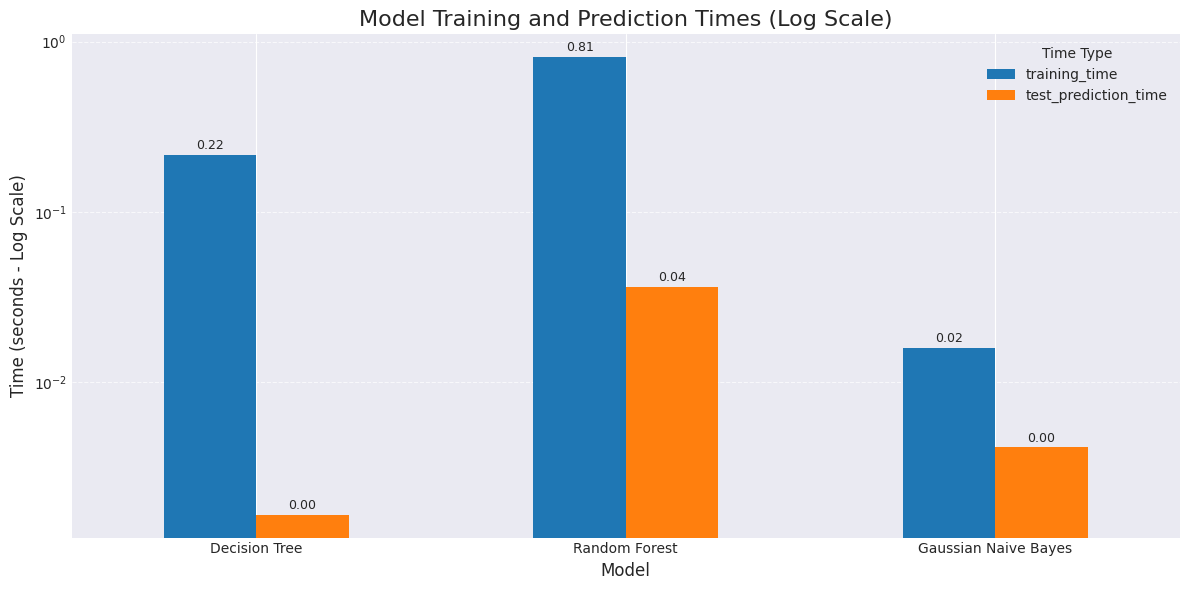

In [36]:
# %% [markdown]
# ## 16. Compare Model Performance
#
# Create plots comparing the key performance metrics (Accuracy, Precision, Recall, F1-Score) and potentially training/prediction times across all evaluated models.

# %%
# --- Visualize Model Comparison ---
print("\n--- Comparing Model Performance Metrics ---")

# Select metrics to plot
metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
plot_df = results_df[metrics_to_plot]

# Plotting
ax = plot_df.plot(kind='bar', figsize=(14, 7), rot=0)
plt.title('Model Performance Comparison on Test Set', fontsize=16)
plt.ylabel('Score (Weighted Avg.)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.05) # Set y-axis limits for better comparison
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend

# Add score labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8, padding=2)

plt.show()

# --- Compare Training and Prediction Times ---
print("\n--- Comparing Model Training and Prediction Times ---")
time_metrics = ['training_time', 'test_prediction_time']
time_df = results_df[time_metrics]

ax_time = time_df.plot(kind='bar', figsize=(12, 6), rot=0, logy=True) # Use log scale if times vary greatly
plt.title('Model Training and Prediction Times (Log Scale)', fontsize=16)
plt.ylabel('Time (seconds - Log Scale)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Time Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add time labels on top of bars
for container in ax_time.containers:
    ax_time.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

plt.show()


# %% [markdown]
# ---
# ## End of Notebook
# ---